<a href="https://colab.research.google.com/github/sweathaamarnath/Autonomous/blob/main/Lane_detection_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries for building the model

In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the resized image (128,128,3) and masked image(128,128,1) of the public dataset

In [3]:
train_images = pickle.load(open("/content/drive/My Drive/images.pkl", "rb" ))
labels = pickle.load(open("/content/drive/My Drive/labels.pkl", "rb" ))

In [4]:
train_images = np.array(train_images)
labels = np.array(labels)

#Shuffle and data split into train and validation set

In [7]:
# Normalize labels - training images get normalized to start in the network
labels = labels / 255

# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)


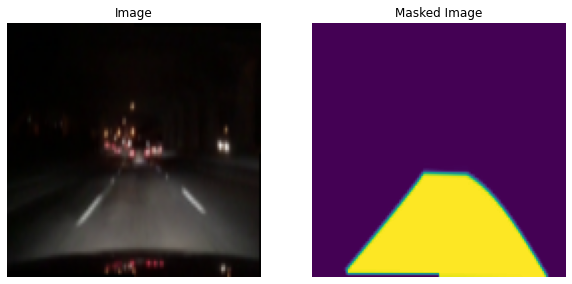

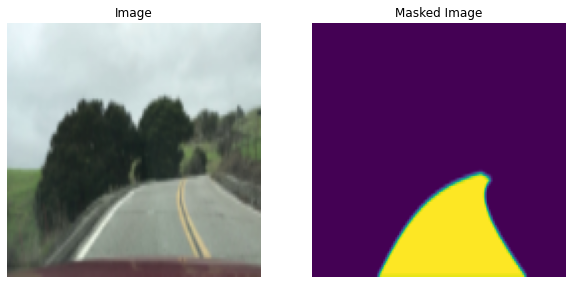

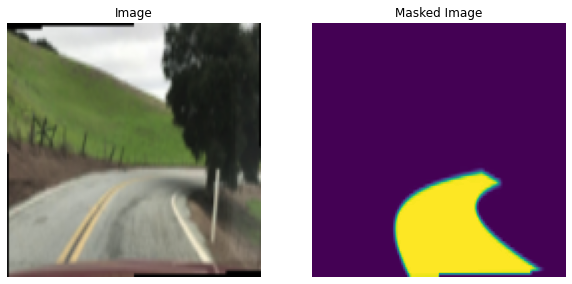

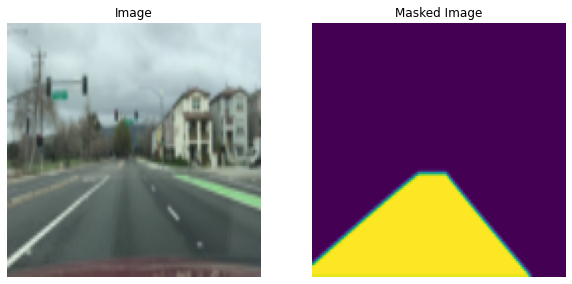

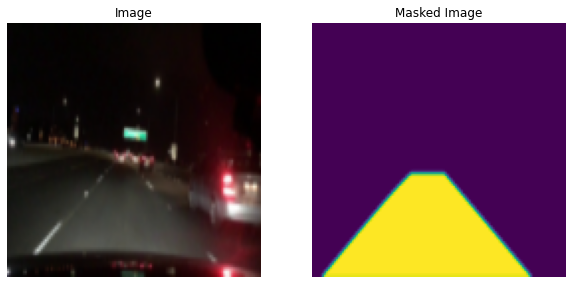

In [8]:
for i in range(5):
  fig, ax = plt.subplots(1, 2, figsize=(10,7))
  ax[0].imshow(train_images[i])
  ax[0].axis("off")
  ax[0].set_title("Image")

  ax[1].imshow(labels[i])
  ax[1].axis("off")
  ax[1].set_title("Masked Image")

  plt.show()

In [9]:
X_train.shape

(11487, 128, 128, 3)

In [10]:
y_train.shape

(11487, 128, 128)

#FCNN Model and training

In [11]:

# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 128
epochs = 10
pool_size = (2, 2)
input_shape = X_train.shape[1:]

# Create the neural network
# Create the actual neural network here
model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
model.add(BatchNormalization(input_shape=input_shape))

# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))

# Conv Layer 4
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
model.add(Dropout(0.2))

# Conv Layer 5
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
model.add(Dropout(0.2))

# Pooling 2
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 6
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
model.add(Dropout(0.2))

# Conv Layer 7
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(Dropout(0.2))

# Pooling 3
model.add(MaxPooling2D(pool_size=pool_size))

# Upsample 1
model.add(UpSampling2D(size=pool_size))

# Deconv 1
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))

# Deconv 2
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
model.add(Dropout(0.2))

# Upsample 2
model.add(UpSampling2D(size=pool_size))

# Deconv 3
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
model.add(Dropout(0.2))

# Deconv 4
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
model.add(Dropout(0.2))

# Deconv 5
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(Dropout(0.2))

# Upsample 3
model.add(UpSampling2D(size=pool_size))

# Deconv 6
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

# Final layer - only including one channel so 1 filter
model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

# Show summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
Conv1 (Conv2D)               (None, 126, 126, 8)       224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 124, 124, 16)      1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 16)        0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 58, 58, 32)        4

In [12]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error', metrics="accuracy")
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,epochs=epochs, verbose=1, validation_data=(X_val, y_val))


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
90/89 [==============================] - 17s 193ms/step - loss: 0.0519 - accuracy: 0.8993 - val_loss: 0.0411 - val_accuracy: 0.9187
Epoch 2/10
90/89 [==============================] - 16s 179ms/step - loss: 0.0169 - accuracy: 0.9376 - val_loss: 0.0196 - val_accuracy: 0.9400
Epoch 3/10
90/89 [==============================] - 16s 182ms/step - loss: 0.0121 - accuracy: 0.9409 - val_loss: 0.0120 - val_accuracy: 0.9416
Epoch 4/10
90/89 [==============================] - 17s 185ms/step - loss: 0.0100 - accuracy: 0.9421 - val_loss: 0.0095 - val_accuracy: 0.9424
Epoch 5/10
90/89 [==============================] - 16s 183ms/step - loss: 0.0088 - accuracy: 0.9430 - val_loss: 0.0084 - val_accuracy: 0.9437
Epoch 6/10
90/89 [==============================] - 16s 181ms/step - loss: 0.0076 - accuracy: 0.9442 - val_loss: 0.0071 - val_accuracy: 0.9446
Epoch 7/10
90/89 [==============================] - 16s 180ms/step

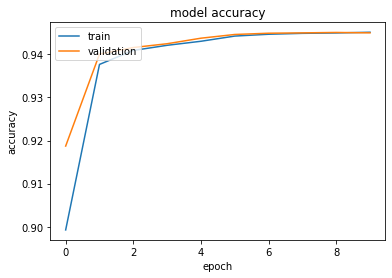

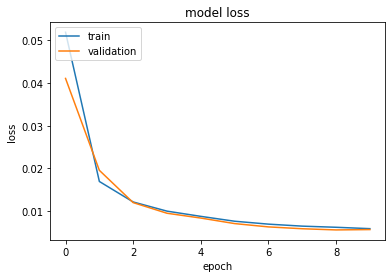

In [13]:
import matplotlib.pyplot as plt
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Test the model prediction

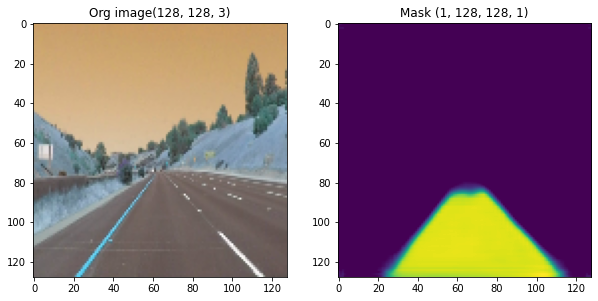

In [17]:
import cv2 

img = cv2.imread("/content/drive/My Drive/solidYellowCurve2.jpg")
img = cv2.resize(img, (128,128))
img = np.array(img)
z = model.predict(img[tf.newaxis, ...])

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(121)
ax.set_title(f'Org image{img.shape}')
ax.imshow(img)

ax2 = fig.add_subplot(122)
ax2.set_title(f'Mask {z.shape}')
ax2.imshow(tf.squeeze(z))

In [18]:
model.save("fullCNN_laneMark.h5")